In [24]:
## Identify fraud from Enron Email

### Enron became a symbol for fraud 
# The spectacular collapse of a giant american company in electric field was not only an end to the company
# but brought also a massive change for the american and global economy. 
# In 2001 Enron announced results for 3rd quarter and at the same time to a big surprise of shareholders a banckruptacy.
# In this project I'd like to focus on the most influencial workers of Enron which are obviously involved in the fraud.
# The most famous is CEO Jeffrey Keith "Jeff" Skilling and a chairman  Kenneth Lay of Enron 
# during most of the time when the crime occured.
# We will see their salaries, bonuses and stocks which are quite interesting.
# 

# Going through given dataset with e-mails within Enron co-workers we will discover a POI - Person of Interest,
# basically a person suspected to participate in the fraud.
# 


In [1]:
# Firstly, let's load the necessary data and packages. 
# I am going to create a dataframe in pandas and then with the use of numpy arrays and matplotlib visualize it.
# To further analysis in classyfing will need Sklearn, GaussianNB,... i co jeszcze?

import sys
import pickle
sys.path.append("../tools/")
import random

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.grid_search import GridSearchCV
from time import time

import pandas as pd
get_ipython().magic(u'matplotlib inline')
from matplotlib import pyplot as plt


### Let's load my dictionary providede by Udacity
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

C:\Users\Marcela\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Marcela\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Let's check the type of my dataset, as we see it's a dictionary
type(data_dict)

dict

In [3]:
# By converting the dictionary to a dataframe with pandas it will be easier and faster to work with it:
enron_dataf = pd.DataFrame.from_records(list(data_dict.values()))


In [4]:
# Previosly the index were numbers, but it's easier to set them as names of employees series:
employees = pd.Series(list(data_dict.keys()))
enron_dataf.set_index(employees, inplace=True)
enron_dataf.head()


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [5]:
# to tez zmien to co on napisal
# Coerce numeric values into floats or ints; also change NaN to zero:
enron_dataf = enron_dataf.apply(lambda x : pd.to_numeric(x, errors = 'coerce')).copy().fillna(0)
enron_dataf.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,...,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,...,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,...,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,...,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0


In [6]:
# from above table we can see that some of the data can be interrupting with our analysis
# so let's get rid off, for example the e-mail address column 

enron_dataf.drop('email_address', 1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,0.0,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,0.0,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,0.0,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0
MORDAUNT KRISTINA M,325000.0,0.0,0.0,0.0,0.0,35018.0,0.0,0.0,0.0,0.0,0.0,1411.0,False,208510.0,0.0,267093.0,0.0,0.0,628522.0,208510.0
MEYER ROCKFORD G,0.0,1848227.0,0.0,0.0,493489.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,False,462384.0,0.0,0.0,22.0,232.0,1848227.0,955873.0
MCMAHON JEFFREY,2600000.0,0.0,0.0,0.0,1104054.0,137108.0,48.0,58.0,26.0,0.0,694862.0,297353.0,False,558801.0,0.0,370448.0,2228.0,2355.0,4099771.0,1662855.0
HORTON STANLEY C,0.0,3131860.0,0.0,0.0,5210569.0,0.0,1073.0,44.0,15.0,0.0,0.0,0.0,False,2046079.0,0.0,0.0,1074.0,2350.0,3131860.0,7256648.0
PIPER GREGORY F,400000.0,1130036.0,-33333.0,0.0,880290.0,43057.0,222.0,61.0,48.0,0.0,0.0,778.0,False,409554.0,-409554.0,197091.0,742.0,1238.0,1737629.0,880290.0


In [7]:
# Let's load the data and answer a few simple questions:

In [8]:
# Here we see the whole data_set

In [9]:
# Let's see what features we have about the Enron's CEO:

enron_dataf.loc['SKILLING JEFFREY K']

bonus                            5.6e+06
deferral_payments                      0
deferred_income                        0
director_fees                          0
email_address                          0
exercised_stock_options        1.925e+07
expenses                           29336
from_messages                        108
from_poi_to_this_person               88
from_this_person_to_poi               30
loan_advances                          0
long_term_incentive             1.92e+06
other                              22122
poi                                 True
restricted_stock             6.84367e+06
restricted_stock_deferred              0
salary                       1.11126e+06
shared_receipt_with_poi             2042
to_messages                         3627
total_payments               8.68272e+06
total_stock_value            2.60937e+07
Name: SKILLING JEFFREY K, dtype: object

In [10]:
print enron_dataf.keys()

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'email_address', u'exercised_stock_options', u'expenses',
       u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value'],
      dtype='object')


In [11]:
# As we see there are 146 people in our dataset. Only 18 of them are POI  - Persons of Interest
enron_dataf['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

In [12]:
## OUTLIERS
##


In [13]:
# to nie działa trzeba cos z tym zrobić

In [14]:
#chyba dam sobie z tym spokój
#enron_dataf.drop['TOTAL', axis = 0, inplace = True]

In [267]:
# Just by reading the file with emails provided by Udacity we see that 'TOTAL' and 'NAN' values bring confusion 
# to the data. Let's remove it.

In [268]:
## This code below doesn't make sense after removing the dictionary : d_enron_dict = pickle.load(open("final_project_dataset.pkl", "r") )
## What am I supposed to do with this?

# As we can see there are some outliers that must be removed for further analysis.
# let's get rid off the total, which could cause a chaos. 
# After that we should remove all NANs and see the 6 top salaries as a list in Enron.


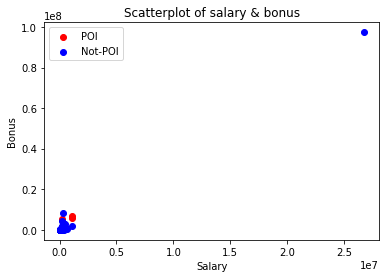

In [15]:
# Let's visualize the salaries and bonuses of ppl in enrone,that's a good way to find outliers

plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == True],enron_dataf["bonus"][enron_dataf["poi"] == True], color = 'r',
           label = "POI")
plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == False],enron_dataf["bonus"][enron_dataf["poi"] == False],color = 'b',
           label = "Not-POI")
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary & bonus")
plt.legend(loc='upper left')
plt.show() 

In [270]:
## So I removed the NaN values too, it's another outlier. Does it have to be visualized aswell?

# Removing the NaN values:
enron_dataf.replace(to_replace= 'NaN', value= 0,inplace=True)

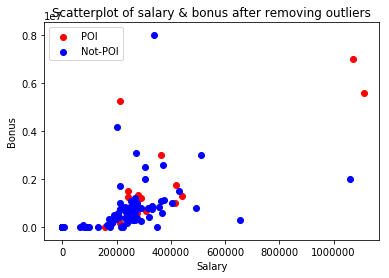

In [16]:
# Now let't eliminate the 'Total' counts!
# The plot brought a more comprehensive view


enron_dataf.drop('TOTAL', axis = 0, inplace = True)

plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == True],enron_dataf["bonus"][enron_dataf["poi"] == True], color = 'r',
           label = "POI")
plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == False],enron_dataf["bonus"][enron_dataf["poi"] == False],color = 'b',
           label = "Not-POI")
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary & bonus after removing outliers")
plt.legend(loc='upper left')
plt.show() 


In [17]:
#clean all 'inf' values which we got if the person's from_messages = 0 o co z tym chodzi?

In [18]:
#enron_df_new = enron_df_new.replace('inf', 0) enron_df_new = enron_df_new.fillna(0)

In [19]:
#### FEATURES
#2. Feature processing of the dataset about ENRON

In [20]:
## My features still don't work :(

# Created two new features in ratios:
enron_dataf['new_feature_from_meassages_to_poi_ratio'] = enron_dataf['from_messages']/enron_dataf['from_poi_to_this_person']
enron_dataf['new_feature_to_messages_from_this_person_to_poi_ratio'] = enron_dataf['to_messages']/enron_dataf['from_this_person_to_poi']

In [21]:
#add our new features to the features list
features_list.append('new_feature_from_meassages_to_poi_ratio')
features_list.append('new_feature_to_messages_from_this_person_to_poi_ratio')

NameError: name 'features_list' is not defined

In [22]:
## So I removed the NaN values too, it's another outlier. Does it have to be visualized aswell? pozmieniaj to kobitko

# Removing the NaN values:
enron_dataf.replace(to_replace= "NaN", value= 0,inplace=True)

In [23]:
enron_dataf.drop('TOTAL', axis = 0, inplace = True)

ValueError: labels ['TOTAL'] not contained in axis

In [24]:
enron_dataf = enron_dataf.replace('NaN', 0)

In [25]:
enron_dataf = enron_dataf.fillna(0)

In [26]:
enron_dataf.replace(to_replace = 'inf', value= 0, inplace=True)

In [27]:
enron_dataf = enron_dataf.astype(np.float64)

In [28]:
enron_dataf.dtypes

bonus                                                    float64
deferral_payments                                        float64
deferred_income                                          float64
director_fees                                            float64
email_address                                            float64
exercised_stock_options                                  float64
expenses                                                 float64
from_messages                                            float64
from_poi_to_this_person                                  float64
from_this_person_to_poi                                  float64
loan_advances                                            float64
long_term_incentive                                      float64
other                                                    float64
poi                                                      float64
restricted_stock                                         float64
restricted_stock_deferred

In [29]:
# Deleting the row with index 'THE TRAVEL AGENCY IN THE PARK'
enron_dataf.replace(to_replace = 'THE TRAVEL AGENCY IN THE PARK', axis = 0, inplace = True) 

C:\Users\Marcela\Anaconda2\lib\site-packages\pandas\core\generic.py:3675: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warn('the "axis" argument is deprecated and will be removed in'


TypeError: cannot replace ['THE TRAVEL AGENCY IN THE PARK'] with method pad on a DataFrame

In [30]:
enron_dataf.drop('email_address', axis = 1, inplace = True)

In [31]:
# Deleting the row with index 'THE TRAVEL AGENCY IN THE PARK'
enron_dataf.drop('THE TRAVEL AGENCY IN THE PARK', axis = 0, inplace = True)

In [32]:
enron_dataf.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,new_feature_from_meassages_to_poi_ratio,new_feature_to_messages_from_this_person_to_poi_ratio
METTS MARK,600000.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,0.0,...,0.0,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0,0.763158,807.000000
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,...,0.0,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0,0.000000,0.000000
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,0.0,...,0.0,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0,0.000000,0.000000
CORDES WILLIAM R,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,...,0.0,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0,1.200000,inf
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,0.0,...,1.0,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0,1.000000,49.761905


In [33]:

# Converting the above modified dataframe to a dictionary
enron_dict = enron_dataf.to_dict('index')

In [34]:
# To make it easier with further exploration let's set my dataset to a dataset
# MY DATASET czy co to ma byc?
my_dataset = enron_dict

In [35]:
# enron_dict = pickle.load(open("final_project_dataset.pkl", "r") )

In [36]:
# Now let's focus on choosing the features to indentify a POI
# I will use only the provided features, POI, financial and email as per below:

# POI

# Features with email: 'from_messages', 'shared_receipt_with_poi',['fraction_mail_from_poi', 'fraction_mail_to_poi', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'from_messages']

# Financial features: ['poi', 'salary', 'bonus','deferral_payments', 'expenses', 
#                 'restricted_stock_deferred', 'restricted_stock', 'deferred_income','total_payments',
#                 'exercised_stock_options', 'total_stock_value', 'restricted_stock']


In [37]:
features_list = ['poi', 'salary', 'bonus', 'deferral_payments', 'expenses', 
                 'deferred_income','total_payments',
                 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 
                 'from_messages', 'shared_receipt_with_poi', 'exercised_stock_options',
                'total_stock_value', 'new_feature_from_meassages_to_poi_ratio', 
                'new_feature_to_messages_from_this_person_to_poi_ratio']

In [38]:
#data_dict = pickle.load(open("my_dataset.pkl", "r") )

In [39]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [40]:
# zmien to tez prosze
# I mus split data into training and testing datasets to run classifiers

from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, 
                                                                                             random_state=42)


In [41]:
## I don't understand why, but yesterday it was all working! Could it be because of the dataframe instead of diciotnary?

from sklearn.naive_bayes import GaussianNB

t0 = time()
#zobacz czy mozna zmienic nazwe tego accuracy score i skad sie to wzielo
clf = GaussianNB()
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
accuracy = accuracy_score(labels_test, prediction)


print "Accuracy for GaussianNB:", accuracy

print "GaussianNB time of running algorithm:", round(time()-t0, 3), "s"

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [42]:
## I don't understand why, but yesterday it was all working! Could it be because of the dataframe instead of diciotnary?

# Another classifer is a Decision Tree,
# it gives certainly bigger accuracy


from sklearn.tree import DecisionTreeClassifier
# jak cos to to teraz dodalam wieczorem
from sklearn.metrics import accuracy_score

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'accuracy', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [43]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(features_train, labels_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [44]:
## I don't understand why, but yesterday it was all working! Could it be because of the dataframe instead of diciotnary?

from sklearn.neighbors import KNeighborsClassifier


clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"
print "Accuracy of DT classifer is  : ",accuracy_score(labels_test, prediction)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [45]:

clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [46]:
##Accuracy can be interpreted as : 85.2% predictions on the total test set have been made correctly.

#Precision can be interpreted as : if a person is being classified as a POI by my classifier then there is a 47.6% chance that the person is actually a POI. (i.e., a 47.6% chance of obtaining a true positive condition.)

#Recall can be interpreted as : of all the actual POIs considered, 37.7% of all the POIs can be classified correctly as a POI by my classifier.



In [47]:
# Create final classifer/ czy to mialoby sens?
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_features=2, min_samples_split=2,
                             criterion='entropy', max_depth=None)

In [48]:
# to bylo po prostu to 
dump_classifier_and_data(clf, my_dataset, features_list)

In [49]:
# With 146 Enron employers, 18 of which are POIs, the dataset used is both small and is imbalanced. zmien to jakos

In [50]:
# moze to potem do validacji?? chyba raczej trzeba uzyc tego pipeline czy cos
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.cross_validation import KFold
kf = KFold(25, n_folds=5, shuffle=False)

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], data[1]))

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     
